# Cross Validation

Nested cross-validation means you apply cross-validation twice (and separately!):
1. Inner CV: for hyperparameter tuning
2. Outer CV: for estimating generalization performance

Nested cross-validation is recommended **when you have "small" or noisy datasets.**

### Contents

**Model**

* Random Forest
* With grid search for hyperparameter tuning via 5-fold inner cross-validation

**Evaluate**

* Single train/test split
* 3-fold (outer) cross-validation

**Notes**

* Explaining models (feature importances)
* _Repeated_ nested cross-validation
* The best single line of machine learning code, ever
* You don't need a holdout dataset
  
### Py script

For the condensed python script, see: TBD

In [1]:
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split, RepeatedStratifiedKFold)
from sklearn.metrics import (accuracy_score, roc_auc_score, average_precision_score,
                             f1_score)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [2]:
random_state = 99

X, y = make_classification(n_samples=1000, n_features=20, n_informative=5, n_redundant=0,
                           random_state=random_state)

# Model

Distinguishing _inner_ cross-validation from _outer_ cross-validation

In [3]:
inner_cv = 5
outer_cv = 3

inner_metric = 'roc_auc'
outer_metrics = ['roc_auc', 'average_precision', 'f1']

verbose = 1

In [4]:
# see pipe.get_params()
param_grid = dict(
    randomforestclassifier__n_estimators=[100, 200],
    randomforestclassifier__min_samples_leaf=[1, 2]
)

In [5]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=random_state)
)

In [6]:
# inner cv is for hyperparameter tuning
estimator = GridSearchCV(estimator=model, param_grid=param_grid, scoring=inner_metric,
                         cv=inner_cv, refit=True, return_train_score=False, verbose=0)

# Evaluate

## Single train/test split

Not recommended for "smaller" or noisier datasets

In [7]:
# "crude" outer cv via single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/outer_cv, random_state=random_state)

In [8]:
estimator.fit(X_train, y_train);

In [9]:
preds_class = estimator.predict(X_test)
preds_probs = estimator.predict_proba(X_test)[:,1] # take probs for y==1

In [10]:
estimator.score(X_test, y_test)

0.9169272237196766

In [11]:
# same as estimator.score() due to `inner_metric`
roc_auc_score(y_test, preds_probs)

0.9169272237196766

In [12]:
# other scores
accuracy_score(y_test, preds_class), roc_auc_score(y_test, preds_class)

(0.8532934131736527, 0.8551123090745734)

## Nested Cross Validation

Preferred, especially for "smaller" or noisier datasets

In [13]:
# outer cv is for estimating generalization performance
cv_results = cross_validate(estimator, X, y, scoring=outer_metrics,
                            cv=outer_cv, verbose=verbose, return_train_score=False,
                            return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.9s finished


In [14]:
pd.DataFrame(cv_results)

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_f1
0,5.618918,0.021799,"GridSearchCV(cv=5,\n estimator=Pip...",0.956847,0.954179,0.865330
1,5.629152,0.040707,"GridSearchCV(cv=5,\n estimator=Pip...",0.937577,0.910025,0.877193
2,5.572243,0.039975,"GridSearchCV(cv=5,\n estimator=Pip...",0.917322,0.897543,0.845714


In [15]:
# You can compute mean, std if you have multiple estimates of generalization performance
cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std()

(0.9372484739776632, 0.0161376018090444)

In [16]:
cv_results['test_f1'].mean(), cv_results['test_f1'].std()

(0.8627455936881363, 0.012980358649081303)

## Final model

To deploy in production, train the final model by re-running _the full modeling procedure_ on the full dataset.

The estimates of this modeling procedure's generalization performance are above, obtained from nested CV.

In [17]:
estimator.fit(X, y);

In [18]:
# deploy (predict) in production
# estimator.predict(X_new)

In [19]:
estimator.best_params_

{'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__n_estimators': 200}

# Notes

## Explaining models
You can inspect feature importances from each of the cross-validated models

They were saved with `cross_validate(..., return_estimator=True)`

In [20]:
# same number of fitted models as outer_cv
len(cv_results['estimator'])

3

In [21]:
fitted_estimators = [x for x in cv_results['estimator']]

In [22]:
# best hyperparameters from Grid Search
[x.best_params_ for x in fitted_estimators]

[{'randomforestclassifier__min_samples_leaf': 1,
  'randomforestclassifier__n_estimators': 100},
 {'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__n_estimators': 200},
 {'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__n_estimators': 200}]

In [23]:
# Getting feature importances requires some digging
# one_estimator = cv_results['estimator'][0]
# one_estimator.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

In [24]:
importances = [x.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
               for x in fitted_estimators]

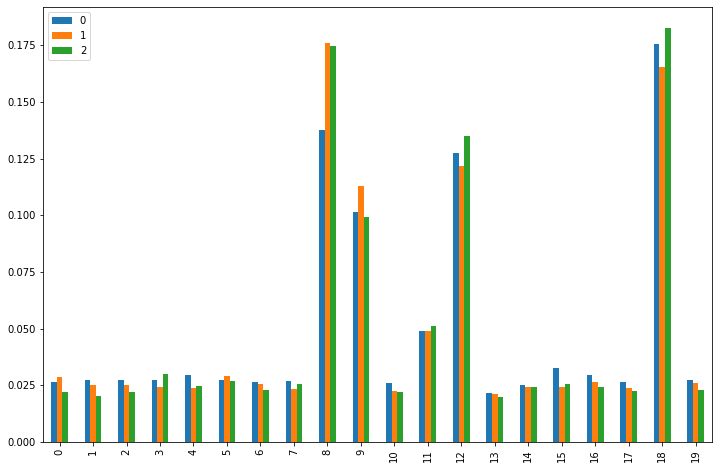

In [25]:
# the number of peaks should match the number of informative features in data generated with `make_classification()`
pd.DataFrame(importances).T.plot.bar(figsize=(12, 8));

## Repeated nested CV
To better assess variance of generalization scores, try _repeated_ nested CV. Use:

```python
from sklearn.model_selection import RepeatedStratifiedKFold

outer_cv_k = 5
outer_cv_repeats = 10

outer_cv = RepeatedStratifiedKFold(n_splits=outer_cv_k, n_repeats=outer_cv_repeats)
```

(How many estimates of generalization performance will that get you?)

## LogisticRegressionCV

To use a linear model, use `sklearn.linear_model.LogisticRegressionCV` in place of `GridSearchCV()`.

Models with `CV` suffix have built-in, efficient CV for hyperparameter selection, and they are _really_ powerful.

Just a couple lines of code get you a long way there

In [26]:
lrcv = make_pipeline(
    StandardScaler(),
    # The best single line of machine learning code ever
    LogisticRegressionCV(Cs=20, cv=inner_cv, scoring=inner_metric, refit=True, random_state=random_state)
)

In [27]:
cv_results = cross_validate(lrcv, X, y, scoring=outer_metrics,
                            cv=outer_cv, verbose=0, return_train_score=False,
                            return_estimator=True)

In [28]:
pd.DataFrame(cv_results)

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_f1
0,0.235589,0.002175,"(StandardScaler(), LogisticRegressionCV(Cs=20,...",0.783857,0.711282,0.739884
1,0.231250,0.002207,"(StandardScaler(), LogisticRegressionCV(Cs=20,...",0.780716,0.735329,0.692771
2,0.224117,0.002145,"(StandardScaler(), LogisticRegressionCV(Cs=20,...",0.777000,0.739947,0.708709


In [29]:
cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std()

(0.7805244427817044, 0.0028027116573389158)

In [30]:
# tuned hyperparameters from this (Ridge/L2) regressor, erm, classifier
[x.named_steps['logisticregressioncv'].C_ for x in cv_results['estimator']]

[array([0.00483293]), array([0.23357215]), array([0.01274275])]

In [31]:
# linear models have coef_ not feature_importances_
importances = [x.named_steps['logisticregressioncv'].coef_.flatten()
               for x in cv_results['estimator']]

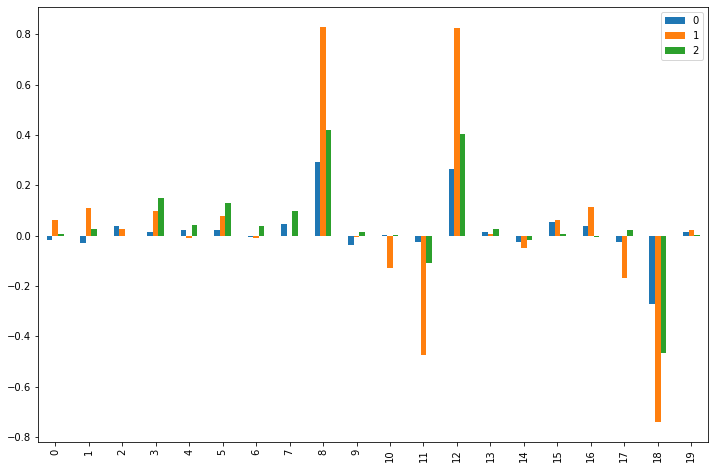

In [32]:
# A bit less clear, but still decent, plus shows direction of effect, not just weight
# Notes that this linear model is worse-performing compared to RF
pd.DataFrame(importances).T.plot.bar(figsize=(12, 8));

## You don't need a holdout dataset

With nested cross validation, you won't learn anything new from a separate holdout dataset. You already have _multiple_ holdout datasets in nested cross validation!

In [33]:
# let's hold-out a "secret" 20% holdout dataset
X_, X_holdout, y_, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

X_.shape, X_holdout.shape, X.shape

((800, 20), (200, 20), (1000, 20))

In [34]:
# use new X_ and y_ with more robust CV assessment
rkf = RepeatedStratifiedKFold(n_splits=outer_cv, n_repeats=5)
cv_results = cross_validate(estimator, X_, y_, scoring=outer_metrics, cv=rkf,
                           verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


In [35]:
score_names = [x for x in cv_results.keys() if 'test' in x]
pd.DataFrame(cv_results)[score_names].describe().T[['mean', 'std', 'count']]

,mean,std,count
test_roc_auc,0.924265,0.015870,15.0
test_average_precision,0.897462,0.027770,15.0
test_f1,0.865765,0.017101,15.0


In [36]:
# Oh, we also have a secret holdout. Will it tell us anything new?

In [37]:
# Fit estimator pipeline on full dataset...
estimator.fit(X_, y_);

In [38]:
# ...And evaluate on the holdout
preds_class = estimator.predict(X_holdout)
preds_probs = estimator.predict_proba(X_holdout)[:,1]

The following scores aren't "new".

Our nested CV results above already told us as much. This holdout dataset didn't teach us anything "new".

In [39]:
roc_auc_score(y_holdout, preds_probs)

0.9389022435897436

In [40]:
average_precision_score(y_holdout, preds_probs)

0.9343756542961916

In [41]:
f1_score(y_holdout, preds_class)

0.8514851485148515